In [1]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import util
from sklearn.decomposition import TruncatedSVD
from data_preprocessing import *
import word_embedding_load as wel
from classification import *
from xgboost_classifier import *
from testaccuracy import *

C:\Users\zhuya\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
C:\Users\zhuya\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
[all_data, train_size, test_size, train_x, train_y, test_x] = util.loadData()
sentences = data_preprocess(all_data)

In [3]:
Text_INPUT_DIM=200
GENE_INPUT_DIM=25
TEXT_INPUT_DIM=200
PATH = '../model/doc2vec/'
modelName='textModel_win=30_no_outside'

In [4]:
param = util.Doc2VecParam(1, 2, 200, 1e-4, 5, 4, 30, 1)

In [5]:
svd = TruncatedSVD(n_components=GENE_INPUT_DIM, n_iter=25, random_state=12)

In [6]:
#load a pre-trained text model
text_model = wel.loadTextModel(PATH + modelName)

#To train a new text model, default without outside data:
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH)

#To train a new text model with outside data:
#sourceFile = '../data/bio_nlp_vec/PubMed-shuffle-win-30.bin'
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH, True, sourceFile)

Successfully loaded the textmodel from ../model/doc2vec/textModel_win=30_no_outside


In [7]:
truncated_one_hot_gene = wel.getGeneVec(all_data, svd)
truncated_one_hot_variation = wel.getVariationVec(all_data, svd)
text_train_arrays, text_test_arrays = wel.getTextVec(text_model, train_size, test_size, TEXT_INPUT_DIM)

In [8]:
print(text_train_arrays.shape)
print(text_test_arrays.shape)
text_train_arrays[0]

(3689, 200)
(986, 200)


array([-0.17289065, -3.8296752 ,  0.06695388,  3.82798338, -0.2867583 ,
       -0.6928432 ,  2.93742371,  2.01823235, -0.32684457, -1.44869399,
        0.27529755, -0.79016078,  1.79306448,  4.28960419,  0.13605687,
       -2.43463802,  0.09181995, -0.04406718,  2.46003342,  4.73867655,
        1.97732508,  2.34663606, -0.11793029, -3.57738924, -0.45679718,
       -3.54198337,  4.34884214,  2.30379629,  4.62182856,  2.40693569,
        1.11229527,  1.03004909, -0.47451738, -1.17208731, -1.95631719,
        0.94235301, -1.72339058,  0.94970924,  1.68300402,  5.48246861,
       -2.90595341,  2.47609782,  2.60338545, -0.22896838,  0.26752338,
        0.79036963, -1.86278892,  1.52235138, -0.40399107, -3.93441987,
       -0.16414452,  3.76050663, -0.12991294,  1.8676033 , -4.16120958,
        1.54574025, -2.70265174,  0.9447946 , -0.35614172,  0.77467412,
        0.18951511, -3.21754813,  1.22369778, -4.41033459,  1.06871235,
       -2.62220693, -1.1595726 , -0.85579103, -4.74306965,  0.44

In [9]:
train_set = np.hstack((truncated_one_hot_gene[:train_size], truncated_one_hot_variation[:train_size], text_train_arrays))
test_set = np.hstack((truncated_one_hot_gene[train_size:], truncated_one_hot_variation[train_size:], text_test_arrays))
encoded_y = pd.get_dummies(train_y)
encoded_y = np.array(encoded_y)
print(encoded_y.shape)

(3689, 9)


In [10]:
print(train_set.shape)
print(test_set.shape)
train_set[0, 25:50]

(3689, 250)
(986, 250)


array([  1.00000000e+00,   4.18523246e-19,   1.82140582e-19,
         5.52932734e-29,   9.01317672e-25,   1.47967745e-22,
        -8.38240178e-21,   2.00300590e-21,   9.74158370e-21,
        -9.34683441e-21,   1.91083889e-20,   6.55003880e-19,
        -1.09276438e-17,  -1.56730196e-18,  -2.12913704e-18,
        -4.51096312e-18,  -3.82900024e-19,   1.15894157e-17,
         1.59938703e-17,   3.58735292e-17,  -3.35304994e-18,
         1.68462844e-17,   6.76851697e-18,   5.86047343e-17,
         7.80129580e-21])

In [11]:
#the xgboost classfication model
#first deal with the input label, transfrom it from 1-9 to 0-8(required by the xgboost)
for i in range(len(train_y)):
    train_y[i] -=1  

[0]	train-mlogloss:2.12136	valid-mlogloss:2.14335
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.12636	valid-mlogloss:1.47589
[50]	train-mlogloss:0.675256	valid-mlogloss:1.20598
[75]	train-mlogloss:0.436221	valid-mlogloss:1.08835
[100]	train-mlogloss:0.29858	valid-mlogloss:1.01638
[125]	train-mlogloss:0.205644	valid-mlogloss:0.984552
[150]	train-mlogloss:0.145017	valid-mlogloss:0.967574
[175]	train-mlogloss:0.104283	valid-mlogloss:0.965492
[200]	train-mlogloss:0.077105	valid-mlogloss:0.965019
[225]	train-mlogloss:0.058967	valid-mlogloss:0.964441
[250]	train-mlogloss:0.045912	valid-mlogloss:0.96622
[275]	train-mlogloss:0.036822	valid-mlogloss:0.970268
[300]	train-mlogloss:0.030353	valid-mlogloss:0.973773
Stopping. Best iteration:
[215]	train-mlogloss:0.065424	valid-mlogloss:0.962906

final validation loss:
0.962906420789
final validation accuracy:
0.6775067750

[50]	train-mlogloss:0.692299	valid-mlogloss:1.20201
[75]	train-mlogloss:0.458963	valid-mlogloss:1.07443
[100]	train-mlogloss:0.317107	valid-mlogloss:1.01145
[125]	train-mlogloss:0.219208	valid-mlogloss:0.974031
[150]	train-mlogloss:0.151165	valid-mlogloss:0.952535
[175]	train-mlogloss:0.107954	valid-mlogloss:0.937861
[200]	train-mlogloss:0.079412	valid-mlogloss:0.933214
[225]	train-mlogloss:0.060281	valid-mlogloss:0.932632
[250]	train-mlogloss:0.047077	valid-mlogloss:0.932818
[275]	train-mlogloss:0.037852	valid-mlogloss:0.930958
[300]	train-mlogloss:0.031261	valid-mlogloss:0.931508
Stopping. Best iteration:
[215]	train-mlogloss:0.066962	valid-mlogloss:0.930294

final validation loss:
0.930293962158
final validation accuracy:
0.644986449864
[0]	train-mlogloss:2.12095	valid-mlogloss:2.14102
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.13982	valid-mlogloss:1.5

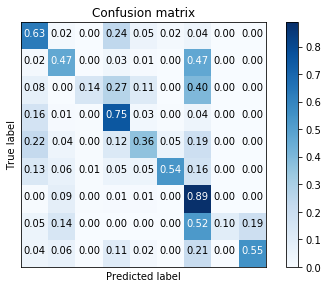

In [12]:
y_predict = xgbclassifier(train_set, train_y, test_set, 10, 8, 1000)

In [13]:
savesubmisstion(y_predict, test_x, filename = "submission_allwin30noload10fold.csv")